In [1]:
import os
import glob
import zipfile
import seaborn as sb
import numpy as np # linear algebra
import pandas as pd # data processing 
from PIL import Image
# from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation, GlobalMaxPooling2D
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
from keras.optimizers import Adam

In [2]:
# Python 3 code to rename multiple
# files in a directory or folder
 
# importing os module
import os
 
# Function to rename multiple files
def main():
   
    folder = "datasets-composite_method/train/2-mycelium_grown"
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"mycelium_grown.{filename}.jpg"
        src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
        dst =f"{folder}/{dst}"
         
        # rename() function will
        # rename all the files
        os.rename(src, dst)
 
# Driver Code
if __name__ == '__main__':
     
    # Calling main() function
    main()

In [3]:
# Function to rename multiple files
def main():
   
    folder = "datasets-composite_method/train/4-fruiting_body_grown-5-spore_massively_produced"
    for count, filename in enumerate(os.listdir(folder)):
        dst = f"fruiting_body_grown-spore_massively_produced.{filename}.jpg"
        src =f"{folder}/{filename}"  # foldername/filename, if .py file is outside folder
        dst =f"{folder}/{dst}"
         
        # rename() function will
        # rename all the files
        os.rename(src, dst)
 
# Driver Code
if __name__ == '__main__':
     
    # Calling main() function
    main()

In [4]:
def prepare_data(dir_path):
    filenames = os.listdir(dir_path)
    labels = []
    for filename in filenames:
        label = filename.split('.')[0]
        if label == 'fruiting_body_grown-spore_massively_produced':
            labels.append(1)
        else:
            labels.append(0)
    return filenames,labels

#prepare data 
train_filenames,train_labels = prepare_data('datasets-composite_method/train') 
test_filenames,test_labels = prepare_data('datasets-composite_method/test1') 

df_train = pd.DataFrame({'filename':train_filenames,'class': train_labels})
df_test = pd.DataFrame({'filename': test_filenames,'class': test_labels})

In [5]:
df_train.head()

filename  class
0  fruiting_body_grown-spore_massively_produced.C...      1
1  fruiting_body_grown-spore_massively_produced.C...      1
2  fruiting_body_grown-spore_massively_produced.C...      1
3  fruiting_body_grown-spore_massively_produced.C...      1
4  fruiting_body_grown-spore_massively_produced.C...      1

In [6]:
df_train.tail()

filename  class
281  mycelium_grown.CMFG0101_20220127T1200.jpg.jpg      0
282  mycelium_grown.CMFG0101_20220127T1400.jpg.jpg      0
283  mycelium_grown.CMFG0101_20220128T1000.jpg.jpg      0
284  mycelium_grown.CMFG0101_20220128T1200.jpg.jpg      0
285  mycelium_grown.CMFG0101_20220128T1400.jpg.jpg      0

In [7]:
df_test.head()

filename  class
0  fruiting_body_grown-spore_massively_produced.C...      1
1  fruiting_body_grown-spore_massively_produced.C...      1
2  fruiting_body_grown-spore_massively_produced.C...      1
3  fruiting_body_grown-spore_massively_produced.C...      1
4  fruiting_body_grown-spore_massively_produced.C...      1

In [8]:
df_test.tail()

filename  class
281  mycelium_grown.CMFG0101_20220127T1200.jpg.jpg      0
282  mycelium_grown.CMFG0101_20220127T1400.jpg.jpg      0
283  mycelium_grown.CMFG0101_20220128T1000.jpg.jpg      0
284  mycelium_grown.CMFG0101_20220128T1200.jpg.jpg      0
285  mycelium_grown.CMFG0101_20220128T1400.jpg.jpg      0

In [9]:
df_train.shape, df_test.shape

((286, 2), (286, 2))

Text(0.5, 1.0, 'Data Distribution')

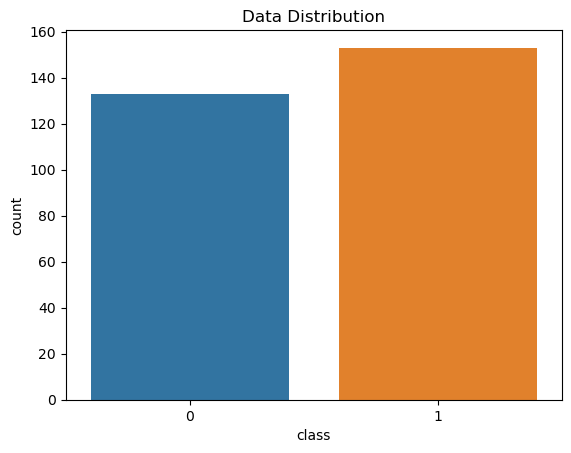

In [10]:
sb.countplot(x='class',data=df_train).set_title("Data Distribution")

In [11]:
len(df_train[df_train['class']==0])

133

In [12]:
# we can see that our dataset is pretty balanced. we will try to reduce the samples
# to ... (exp. 2000) for each class since we will use a pretrained model
# mycelium_grown = df_train[df_train['class']==0][:100]

mycelium_grown = df_train[df_train['class']==0][:]
# fruiting_body_grown_spore_massively_produced = df_train[df_train['class']==1][:100]
fruiting_body_grown_spore_massively_produced = df_train[df_train['class']==1][:133]
#concat the two dataframes
df = pd.concat([mycelium_grown,fruiting_body_grown_spore_massively_produced])
#shuffle
df = df.sample(frac=1)
df.shape

(266, 2)

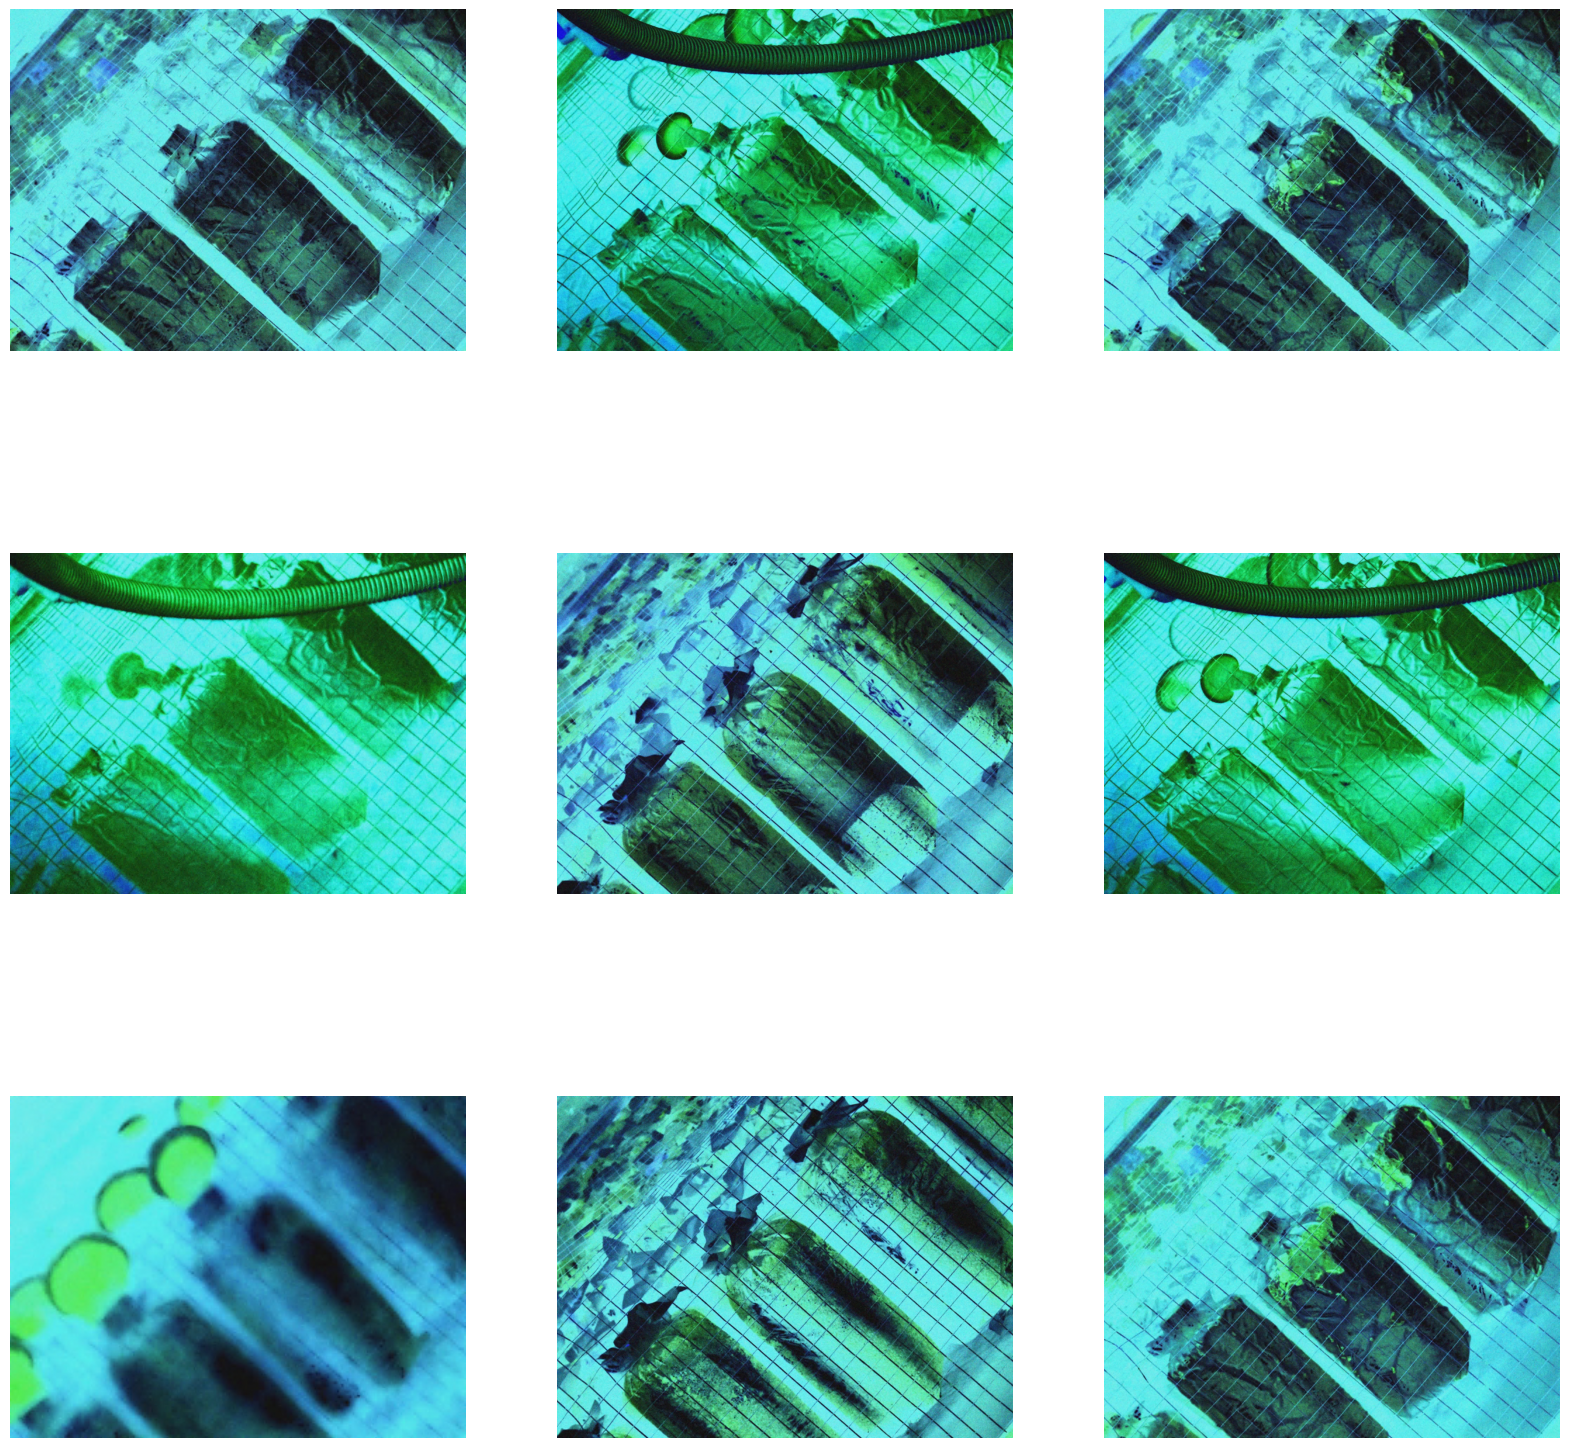

In [14]:
DIR_PATH = 'datasets-composite_method/train/'
#Let's show some image from the dataframe
fig, axis = plt.subplots(3, 3, figsize=(20, 20))
for i, ax in enumerate(axis.flat):
    img = load_img(DIR_PATH+df['filename'].iloc[i]) 
    ax.imshow(img)
    ax.axis('off')

In [15]:
#set some parameters 
image_shape = (224,224)
epochs = 5
batch_size = 32
# to avoid type errors we cast df columns to string opjects
df['filename'] = df['filename'].astype('str')
df['class'] = df['class'].astype('str')
#split data ibto train and validation set
train, validation = train_test_split(df, test_size=0.2)
#reset indexes 
train = train.reset_index()
validation = validation.reset_index()

#data augmenetation 
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

#train generator 
train_generator = train_gen.flow_from_dataframe(
    train, 
    directory = DIR_PATH,
    x_col='filename',
    y_col="class",
    class_mode="categorical",
    target_size=image_shape,
    batch_size=batch_size)

#validation generator 
validation_gen = ImageDataGenerator(
    rescale=1./255)

val_generator = validation_gen.flow_from_dataframe(
    validation,  
    directory = DIR_PATH,
    x_col='filename',
    y_col="class",
    class_mode="categorical",
    target_size=image_shape,
    batch_size=batch_size)

Found 212 validated image filenames belonging to 2 classes.
Found 54 validated image filenames belonging to 2 classes.


Found 1 validated image filenames belonging to 1 classes.


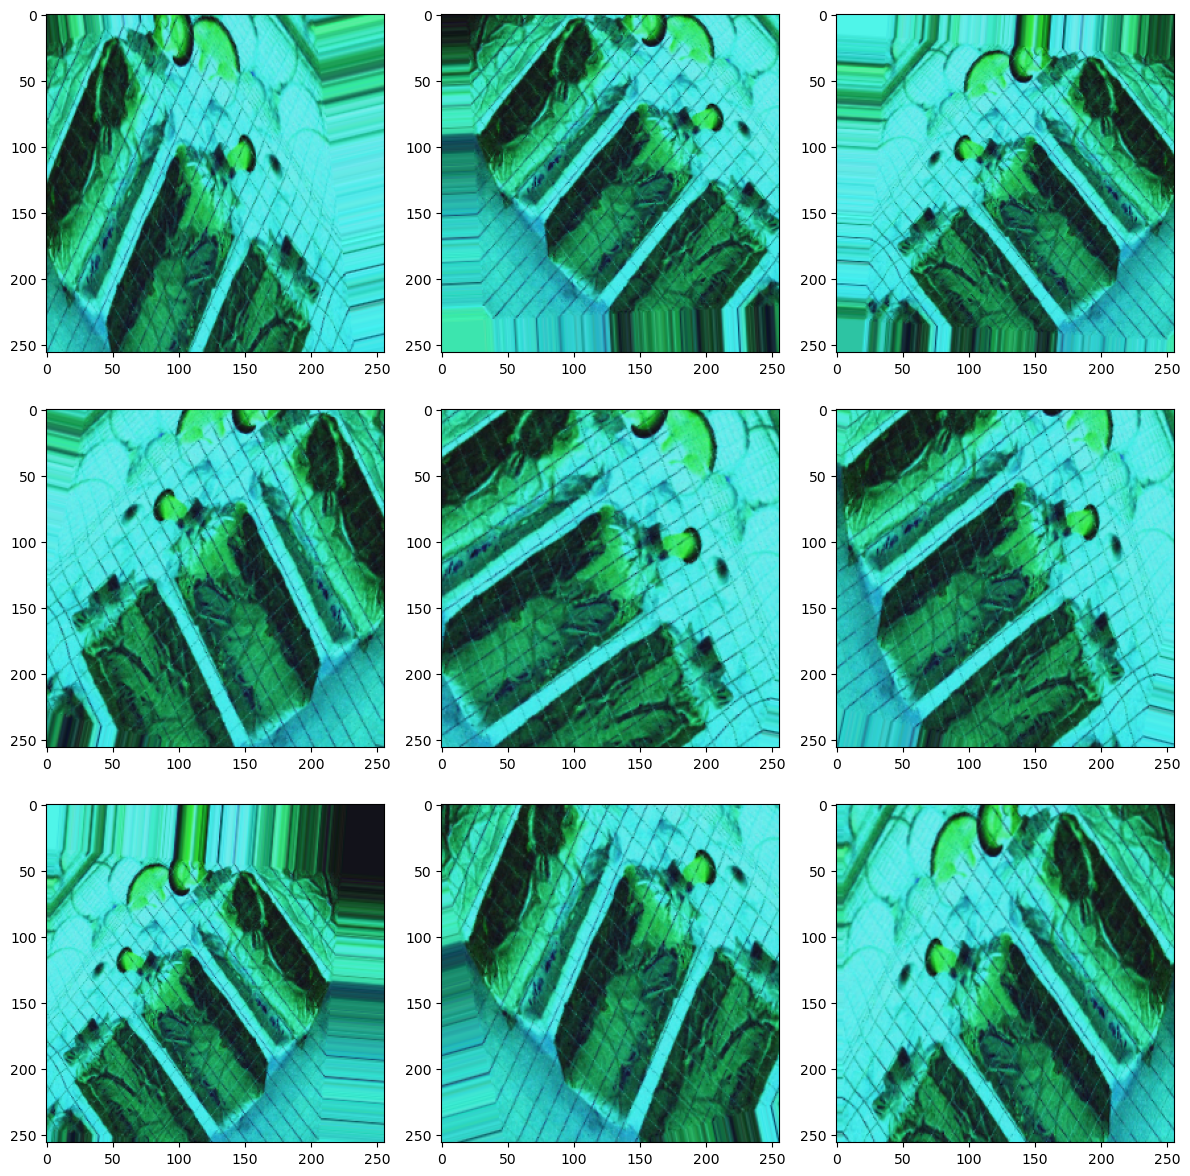

In [16]:
sample_image= train.sample(n=1).reset_index(drop=True)
sample_generator = train_gen.flow_from_dataframe(
    sample_image,
    directory = DIR_PATH,
    x_col='filename',
    y_col='class')
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in sample_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [17]:
#build the Resnet model 
resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False)  


#show the base model summary 
resnet.summary()
#show how manay layers in the Resnet Network
layers = resnet.layers
print(f'Number of Layers: {len(layers)} ')

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [18]:
# number of samples for each set 
size_train = train.shape[0]
size_val = validation.shape[0]
# early stopping 
callbacks = EarlyStopping(patience = 3, monitor='val_acc')
                        
# let's train our Model 
inputs = resnet.input
# add an average pooling layer
x = resnet.output
x = GlobalAveragePooling2D()(x)
#first dense layer
x = Dense(512, activation='relu')(x)
#dropout 
x = Dropout(0.5)(x)
# output layer
outputs = Dense(2, activation ='softmax')(x)
# this is the model we will train
model = Model(inputs=inputs, outputs=outputs)

# freeze all convolutional Resnet layers
for layer in layers:
    layer.trainable = False
# compile the model 
model.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# train the model on the new data for a few epochs
history = model.fit_generator(
    train_generator,
    epochs= epochs,
    validation_data = val_generator,
    validation_steps = size_val//batch_size,
    steps_per_epoch = size_train//batch_size,
    callbacks = [callbacks])

C:\Users\DEL\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\DEL\AppData\Local\Temp\ipykernel_17056\1954572239.py:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
6/6 [==============================] - 37s 6s/step - loss: 0.9886 - accuracy: 0.5611 - val_loss: 0.6742 - val_accuracy: 0.5000
Epoch 2/5
6/6 [==============================] - 31s 5s/step - loss: 0.8138 - accuracy: 0.5833 - val_loss: 0.4265 - val_accuracy: 0.8438
Epoch 3/5
6/6 [==============================] - 28s 5s/step - loss: 0.5964 - accuracy: 0.7111 - val_loss: 0.2990 - val_accuracy: 0.9062
Epoch 4/5
6/6 [==============================] - 28s 5s/step - loss: 0.4830 - accuracy: 0.7611 - val_loss: 0.3156 - val_accuracy: 0.8750
Epoch 5/5
6/6 [==============================] - 35s 6s/step - loss: 0.4922 - accuracy: 0.7278 - val_loss: 0.2965 - val_accuracy: 0.9062


Text(0.5, 0, '#epochs')

<Figure size 640x480 with 0 Axes>

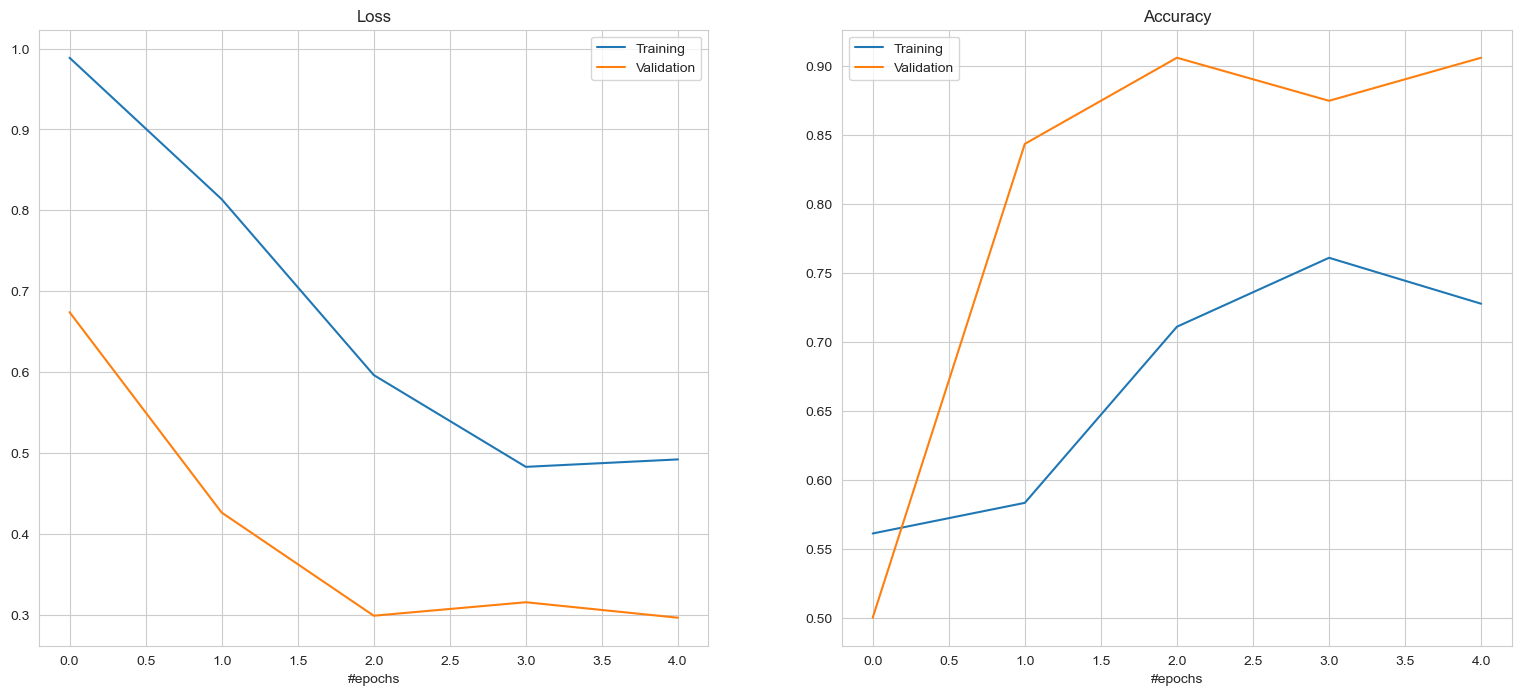

In [19]:
# Plot training loss vs validation loss
sb.set_style('whitegrid')
plt.figure()
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(19,8))
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Training','Validation'])
ax1.set_title('Loss')
ax1.set_xlabel('#epochs')
## plot training accuracy vs validation accuracy 
ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.legend(['Training','Validation'])
ax2.set_title('Accuracy')
ax2.set_xlabel('#epochs')

In [20]:
#Evaluate
loss, acc = model.evaluate_generator(val_generator)
print("Validation Accuracy = %f \nValidation Loss = %f " % (acc, loss))

C:\Users\DEL\AppData\Local\Temp\ipykernel_17056\598698502.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(val_generator)


Validation Accuracy = 0.870370 
Validation Loss = 0.309867 


In [21]:
#save the weights of the model to hdf5 file 
model.save_weights("resnet_model-Composite_Method.h5")
print("Model Saved.")

Model Saved.


C:\Users\DEL\AppData\Local\Temp\ipykernel_17056\2488663289.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict =  model.predict_generator(val_generator)


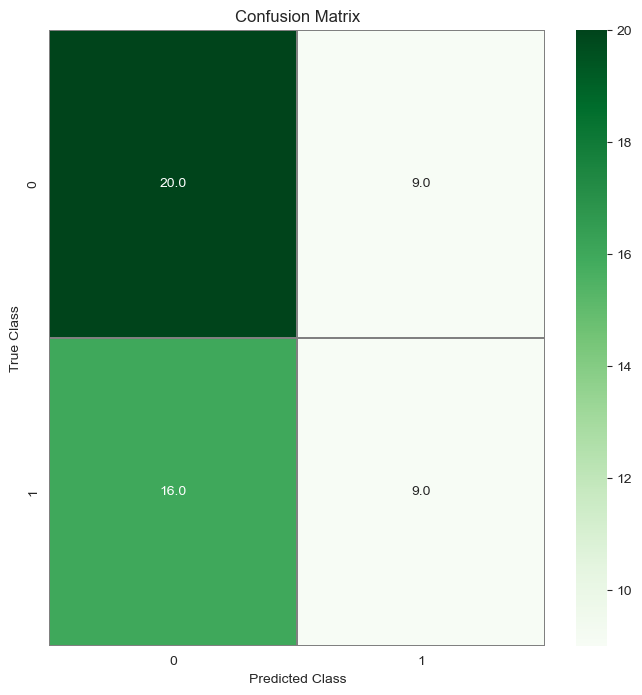

In [22]:
labels = validation['class'].astype('int32')
predict =  model.predict_generator(val_generator)
predictions = np.where(predict > 0.5, 1,0)
predictions = np.argmax(predictions, axis=1)
#show the confusion matrix 
conf_matrix = confusion_matrix(labels, predictions) 
# plot the confusion matrix
fig,ax = plt.subplots(figsize=(8, 8))
sb.heatmap(conf_matrix, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(labels, predictions)
print("Accuracy score: {}".format(acc))

Accuracy score: 0.5370370370370371
